## Elementary Examples in Inverse Dynamics

Falk Mielke, FunMorph, Universiteit Antwerpen

You can download this notebook [here](user://notebooks/ID_LMX2_Vinyl.ipynb?download&target=_blank).

This is one part of a series of blog posts on Inverse Dynamics.
- [Prologue A: Wrench Town Rock](../id_lmx0a_wrenches)
- [Prologue B: The Fictitious Force Awakens](../id_lmx0b_fforces)
- [Elementary Example 1: Stuttering Motor (Euler Force)](../id_lmx1_stutter)
- [Elementary Example 2: Needle On A Vinyl (Centrifugal Force)](../id_lmx2_vinyl)
- [Elementary Example 3: Radial Slider (Coriolis Force)](../id_lmx3_slider)
- [Application: N-Link Inverse Dynamics](../id_lmx4_nlink)

In [1]:
import numpy as NP # numerics
import sympy as SYM # symbolic operations
import sympy.physics.mechanics as MECH # some physics/mechanics tools
import matplotlib.pyplot as MPP # plotting

import WrenchToolbox as WT # contains an improved "Wrench" object

# printing of formulas
SYM.init_printing(use_latex='mathjax', pretty_print = False)
MECH.init_vprinting(use_latex='mathjax', pretty_print = False)


# shorthand to get the basis of a reference frame
GetCoordinates = lambda rf: [rf[idx] for idx in rf.indices]

# transforming a sympy vector to a matrix
MatrixToVector = lambda mat, rf: sum([elm * base for elm, base in zip(mat, GetCoordinates(rf)) ])


# Steiner's Theorem, generalized form 
# [modern robotics, page 245]
GeneralizedSteiner = lambda mass, columnvector: \
                        SYM.simplify( \
                             mass * ( (columnvector.T*columnvector)[0] * SYM.eye(3) \
                                      - columnvector*columnvector.T \
                                    ) \
                             )

The custom Wrench Toolbox [can be downloaded here.](http://mielke-bio.info/share/WrenchToolbox.py?download&target=_blank)

# Elementary Example 1: A Needle On A Vinyl

This is one of my favorite examples.

In my basic physics courses, we covered an exercise involving a massless person on a centrifuge, who would stretch their arms in and out. 
There also was an assessment with James Bond, traversing [Dr Evil's evil centrifuge](https://xkcd.com/123?target=_blank). 
I never remembered the solutions, but these kind of settings were entertaining. 

In memory of these fun undergrad exercises, I'll dedicate this post to all the physics tutors and supervisors who have to come up with simple (thereby solvable) problems just entertaining enough to keep students motivated.

Consider the following situation:

<img src="images/id_lmx_2.svg" width="500px"> </img>

As before, there is a central rotation in the problem. 
Think of it as a (massless) vinyl peacefully rotating on a record player. 
After some strenuous argument, my supervisors and I have concluded that the record should best be one of "The Rolling Stones". 

(Feel free to go now and play a record while reading on.)

The argument was strenuous because I suggested to attach a (massless) needle to the record, which you certainly should not do with real records, and most certainly not with those of your supervisor. 
That needle would be positioned at radius $l$ (as in "length") from the center, pointing upwards. 
At the tip, at height $h$, there would be a point mass of mass $m$. 


Too abstract? Here is a biologically motivated, analogous situation.

Chances are that you are sitting on an office chair right now. 
Please follow me on this exercise:
- Roll a bit back from your table, so that you have an arm's length space in all directions (the biological arm's length principle).
- Now stretch out one arm and hand (palm facing upwards).
- Next, flex your elbow, so that the hand is above your elbow.
- Self-administer some rotational acceleration to your chair, e.g. by the feet or by a fancy remote control and motor. You should now rotate about a vertical axis, close to your spine.

Fun, right? Do you feel a force pulling out your arm? 
Hint: if not, go faster or ask a colleague to spin you.
Second hint: if you are concerned about statistics on this exercise, better increase sample size. 

If you felt a pulling force, that one is actually a fictitious force. The **Centrifugal force**. 
We will isolate it in the example below.


Or, at least, I hope to isolate it. 
The most sensitive ones among my readers might have also felt a **Coriolis force**. 
Or not? 
Theoretically, there shouldn't be one. 
But this notebook below holds a little surprise.

# Definitions

Again, we need a zoo of `sympy` symbols. But the procedure is analogous to the [introductory example](../lmx0_wrenches).

In [2]:
# time, length, mass, gravitational acceleration, height (i.e. second segment length)
t, l, m, h = SYM.symbols('t, l, m, h', real = True)

# set the period of rotation
period = SYM.symbols('T', real = True)

# this defines the angular velocity by 2π/T
φdot = 2.*SYM.pi/period 

# the angle φ is a function of time
φ = SYM.Function('φ')(t)

# the angular velocity is equal to the first derivative of the angle
φ_function = SYM.integrate(φdot, t)

# we will store this for substitution later, 
# for being able to calculate with angles, and then break it down to time.
φ_substitutes = {φ: φ_function}

φ_substitutes

{φ: 2.0*pi*t/T}

We will also meet that handy `PlugAllIn` function again.

In [3]:
constants = {  l: 1. # m \
             , h: 0.25 # m \
             , m: 1. # kg \
             , period: 2.*SYM.pi # s \
             , SYM.pi: NP.pi # = 3.0 \
            }

# this function will substitute and simplify
PlugAllIn = lambda expression: SYM.simplify(SYM.nsimplify(SYM.simplify( \
                                  expression.subs(φ_substitutes).doit().subs(constants).subs(constants) \
                                )))

# Reference Frames

As before, there is a static `world` $\{S\}$ in which our system (`body` $\{B\}$) rotates.

In [4]:
world = MECH.ReferenceFrame('S')

# initialize the {B} frame as rotated relative to the world by φ around the world's z axis.
body = world.orientnew('B', 'Axis', (φ, world.z))

# we give the body frame angular velocity and acceleration
body.set_ang_vel(world, φdot*world.z)
body.set_ang_acc(world, φdot.diff(t)*world.z) # should be zero in our case

body.ang_vel_in(world).to_matrix(world).T

Matrix([[0, 0, 2.0*pi/T]])

Here comes the dictionary with the transformation matrices:

In [5]:
# prepare a list of (label/frame) tuples.
frames = [('S', world), ('B', body)]

# "trafo" dict will store transformation matrices "to" any frame "from" another frame.
trafo = {label: {} for label, _ in frames}
for label_from, frame_from in frames:
    for label_to, frame_to in frames:
        trafo[label_to][label_from] = SYM.simplify(frame_to.dcm(frame_from))

# display example
PlugAllIn(trafo['S']['B'])

Matrix([
[cos(t), -sin(t), 0],
[sin(t),  cos(t), 0],
[     0,       0, 1]])

All of these transformations will look somehow familiar after a few notebooks. 
But does this rotation matrix make sense?

# Points

This time, compared to the introduction, there is a kink in the system: the joint (elbow joint in the office chair experiment). And as opposed to the introductory settings, the joint does not coincide with the origin.

We define the chain of segments from proximal (origin) to distal (point mass).

In [6]:
### define the origin
origin = MECH.Point('O')

# the origin does never move
origin.set_vel(world, 0)
origin.set_acc(world, 0)


### the joint
joint = MECH.Point('J')
joint.set_pos(origin, l * body.y)

## set position vector time derivatives
# (i) in the body frame
joint.set_vel(body, 0)
joint.set_acc(body, 0)

# (ii) in the static frame
joint.set_vel(world, joint.pos_from(origin).diff(t, world).simplify())
joint.set_acc(world, joint.vel(world).diff(t, world).simplify())



### a point mass at a height above the joint
pointmass = MECH.Point('C')

# iteratively initialize pointmass
pointmass.set_pos(joint, h * body.z)
    
# points do not move relative to the body frame
pointmass.set_vel(body, pointmass.pos_from(joint).diff(t, body).simplify())
pointmass.set_acc(body, pointmass.vel(body).diff(t, body).simplify())

# set velocity/acceleration of point in static rf
pointmass.set_vel(world, pointmass.pos_from(origin).diff(t, world).simplify())
pointmass.set_acc(world, pointmass.vel(world).diff(t, world).simplify())

    
# print the point accelerations
SYM.pprint(PlugAllIn(pointmass.pos_from(origin).express(world).to_matrix(world)).T)
SYM.pprint(PlugAllIn(pointmass.vel(world).express(world).to_matrix(world)).T)
SYM.pprint(PlugAllIn(pointmass.acc(world).express(world).to_matrix(world)).T)

[-sin(t)  cos(t)  1/4]
[-cos(t)  -sin(t)  0]
[sin(t)  -cos(t)  0]


Note that the point mass is also the COM.

# Inertial Properties

Again, point mass brings no mass moment of inertia relative to its position - but when taken relative to joint or origin, a Steiner component emerges.

In [7]:
# zero inertia relative to the com (because we have point masses)
inertia = MECH.inertia(body, 0, 0, 0)

I_B = {}
# the system has an inertia relative to the origin, which coincides with the center of mass.
for pt, refpoint in [('P', pointmass), ('J', joint), ('O', origin)]:
    I_B[pt] = inertia.to_matrix(body)\
                + GeneralizedSteiner(  m, pointmass.pos_from(refpoint).express(body).to_matrix(body) ) 


# all the I's can be transformed to the inertial reference frame
I_S = {}
for refpoint in I_B.keys():
    I_S[refpoint] = SYM.simplify(trafo['S']['B'] * I_B[refpoint] )

# print an example
PlugAllIn(I_S['O'])

Matrix([
[17*cos(t)/16, -sin(t)/16,  sin(t)/4],
[17*sin(t)/16,  cos(t)/16, -cos(t)/4],
[           0,       -1/4,         1]])

Even though it is just a point mass, $I$ can get respectably complex.

# Kinematics


As usual, we would like to exactly know each object's position and rotation for all times. 

In [8]:
# shorthands for the derivative levels
p = 0 # zero'th derivative: the position vector
v = 1 # first derivative: the velocity
a = 2 # second derivative: the acceleration

In [9]:
# prepare an empty dictionary
x = {}

# start with the position vectors
x['S'] = {pt: [pointmass.pos_from(refpoint).express(world).to_matrix(world)] \
          for pt, refpoint in [('O', origin), ('J', joint), ('P', pointmass)] \
         }
x['B'] = {pt: [pointmass.pos_from(refpoint).express(body).to_matrix(body)] \
          for pt, refpoint in [('O', origin), ('J', joint), ('P', pointmass)] \
         }

# automatically get time derivatives, in loops
# loop reference frames
for frame in x.keys():
    # loop reference points
    for refpoint in x[frame].keys():
        # loop differentials
        for diff_nr in range(2): 
            x[frame][refpoint].append(SYM.simplify(x[frame][refpoint][-1].diff(t)))


Analogously, store the rotational movement in an $\omega$ dictionary. Once more, $\omega$ is identical to $\varphi$, because the example is simple. However, I prefer the distinct notation of $\omega$ as the total angle of rotation of the "free body" in the world.

In [10]:
# the same dictionary magic as above
ω = {}

# angular positions
ω['S'] = [SYM.Matrix([[0],[0],[φ]])]
ω['B'] = [SYM.Matrix([[0],[0],[0]])]

# time derivatives
for frame in ω.keys():
    for diff_nr in range(2): 
        ω[frame].append(SYM.simplify(ω[frame][-1].diff(t)))

# quick check:
SYM.pprint(PlugAllIn(ω['S'][v] - body.ang_vel_in(world).to_matrix(world)).T)
SYM.pprint(PlugAllIn(ω['B'][v] - body.ang_vel_in(body).to_matrix(body)).T)

[0  0  0]
[0  0  0]


# Visualization

... using `lambdify`.

In [11]:
time = NP.linspace(0., 2*NP.pi, 60, endpoint = False)
position = SYM.lambdify(t, PlugAllIn(x['S']['O'][0]), 'numpy')
lin_velocity = SYM.lambdify(t, PlugAllIn(x['S']['O'][1]), 'numpy')
lin_acceleration = SYM.lambdify(t, PlugAllIn(x['S']['O'][2]), 'numpy')
ang_velocity = SYM.lambdify(t, PlugAllIn(ω['S'][1]), 'numpy')
ang_acceleration = SYM.lambdify(t, PlugAllIn(ω['S'][2]), 'numpy')
# position(time)

<lambdifygenerated-1>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return (array([[-sin(t)], [cos(t)], [1/4]]))


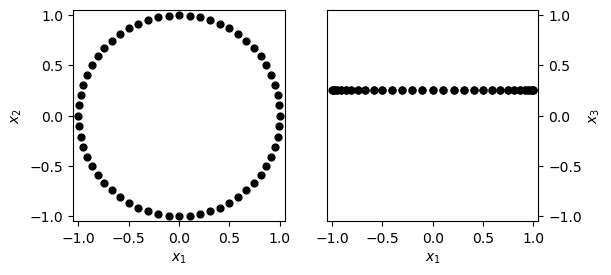

In [12]:
y = [pos[0] for pos in position(time)] 


fig = MPP.figure(dpi = 100)

ax = fig.add_subplot(1,2,1,aspect = 'equal')
ax.scatter(y[0], y[1], s = 24 \
           , color = 'k' \
           , marker = 'o' \
           , alpha = 1. \
          )
ax.set_xlim(NP.array([-1.05,1.05])*(constants[l]))
ax.set_ylim(NP.array([-1.05,1.05])*(constants[l]))
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')

ax = fig.add_subplot(1,2,2,aspect = 'equal')
ax.scatter(y[0], NP.ones((len(y[0]),))*y[2], s = 24 \
           , color = 'k' \
           , marker = 'o' \
           , alpha = 1. \
          )
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()
ax.set_xlim(NP.array([-1.05,1.05])*(constants[l]))
ax.set_ylim(NP.array([-1.05,1.05])*(constants[l]))
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_3$')

MPP.show();

You might argue that this was a bit overkill to draw a circle. Indeed. So let's do more with it.


# Balance of Wrenches

Recall the following important equations which I derived from conservation of momentum. 
If the only external force acting on the "needle/point mass" body we have here is the joint force $F_J$ and Moment $M_J$, then we have in the inertial frame:

$ F_{JS} = m\ddot{x} + \frac{\partial m}{\partial x} \dot{x}\dot{x} = m\ddot{x}  $

$M_{JS} = I\ddot{\omega} + \dot{\omega} \times I\dot{\omega}$

We will use wrenches to get combined results for forces and moments.

## Inertial Frame

The wrench we are looking for is the joint wrench. 
If it were not there, the point mass would fly off our record in tangential direction.

In [13]:
force_components_S = SYM.symbols('f_{JS1:4}', real = True)
moment_components_S = SYM.symbols('m_{JS1:4}', real = True)

joint_wrench_S = WT.Wrench.FromComponents(world, joint, force_components_S, moment_components_S)

SYM.pprint(joint_wrench_S.Matrix().T)


[f_{JS1}  f_{JS2}  f_{JS3}  m_{JS1}  m_{JS2}  m_{JS3}]


Here is the dynamic wrench, taken at the center of (point) mass. 

In [14]:
# we'll need to sum up the points individually
dynamic_force_S = m*x['S']['O'][a]
SYM.pprint(PlugAllIn(dynamic_force_S).T)

# I's are already a sum of two points' inertias
dynamic_moment_S = I_S['P']*ω['S'][a] + ω['S'][v].cross(I_S['P']*ω['S'][v]) 
SYM.pprint(PlugAllIn(dynamic_moment_S).T)

# assembling the dynamic wrench (at the COM)
dynamic_wrench_S = WT.Wrench.FromMatrices(world, pointmass, dynamic_force_S, dynamic_moment_S \
                       )

# because it was assembled at the COM, we must translate the wrench to the joint
dynamic_wrench_S = dynamic_wrench_S.Translate(joint)

PlugAllIn(dynamic_wrench_S.Matrix()).T

[sin(t)  -cos(t)  0]
[0  0  0]


Matrix([[sin(t), -cos(t), 0, cos(t)/4, sin(t)/4, 0]])

Note how translating the wrench altered the moment (because torque/moment always depend on a reference point), but does not change the force (because we shift along a rigid body).

As usual: assemble equations and solve.

In [15]:
# get the equations (one per component)
equations_S = dynamic_wrench_S.Equate(joint_wrench_S)

# desired outcome variables
components_S =  [*force_components_S, *moment_components_S]

# extract the solution
solutions = {}
for param, sol in SYM.solve(equations_S \
                           , components_S \
                           ).items():
    solutions[param] = sol

# transform the result into a wrench
W_JS = WT.Wrench.FromMatrix(world, joint, SYM.Matrix([[solutions[cmp]] for cmp in components_S]) )
SYM.pprint(PlugAllIn(W_JS.Matrix()).T)

⎡                    cos(t)  sin(t)   ⎤
⎢sin(t)  -cos(t)  0  ──────  ──────  0⎥
⎣                      4       4      ⎦


This is our reference. There are no fictitious forces in the inertial frame, so (assuming that this calculation is correct) the six-element vector you see above is the actual net joint wrench. 

The force that appears is the centri**petal** force. 
It holds the rigid body on its regular circumference, by changing the direction of velocity, without changing its magnitude (the acceleration is perpendicular to the instantaneous velocity). 
And because the center of mass is not in line with the origin and joint, there is also a joint moment. 
Both are neatly combined in the joint wrench. 

If we perform the calculation in other reference frames, we would get the same results. 
At least in theory. 
Let's try!

## Body Frame

Let's first get everything in place.

### Balance Components

The left hand side, dynamic wrench:

In [16]:
dynamic_force_B = m*x['B']['J'][a]

dynamic_moment_B = I_B['P']*ω['B'][a] + ω['B'][v].cross(I_B['P']*ω['B'][v])

# assembling the dynamic wrench
dynamic_wrench_B = WT.Wrench.FromMatrices(body, pointmass, dynamic_force_B, dynamic_moment_B \
                       ).Translate(joint)


PlugAllIn(dynamic_wrench_B.Matrix()).T

Matrix([[0, 0, 0, 0, 0, 0]])

The unknown joint wrench as the only external influence:

In [17]:
force_components_B = SYM.symbols('f_{JB1:4}', real = True)
moment_components_B = SYM.symbols('m_{JB1:4}', real = True)

joint_wrench_B = WT.Wrench.FromComponents(body, joint, force_components_B, moment_components_B)

SYM.pprint(joint_wrench_B.Matrix().T)

[f_{JB1}  f_{JB2}  f_{JB3}  m_{JB1}  m_{JB2}  m_{JB3}]


And the fictitious wrenches:

In [18]:
euler_wrench = WT.Wrench(body, pointmass \
            , MatrixToVector(-m * trafo['B']['S'] * (ω['S'][a].cross(x['S']['O'][p])), body) \
             ).Translate(joint)

SYM.pprint(PlugAllIn(euler_wrench.Translate(joint).Matrix()).T)

[0  0  0  0  0  0]


Euler matches our expectations.

In [19]:
centrifugal_wrench = WT.Wrench(body, pointmass \
            , MatrixToVector(-m* trafo['B']['S'] * (ω['S'][v].cross(ω['S'][v].cross(x['S']['O'][p]))), body) \
             ).Translate(joint)

SYM.pprint(PlugAllIn(centrifugal_wrench.Matrix()).T)

[0  1.0  0  -0.25  0  0]


Centrifugal wrench looks promising!

In [20]:
coriolis_wrench = WT.Wrench(body, pointmass \
            , MatrixToVector(-2*m* trafo['B']['S'] * (ω['S'][v].cross(x['S']['O'][v])), body) \
             ).Translate(joint)

SYM.pprint(PlugAllIn(coriolis_wrench.Translate(joint).Matrix()).T)

[0  2.0  0  -0.5  0  0]


**Wait, what?!** 

I did use $F_{cor} = -2m\dot{\omega} \times \dot{x}$

... and I transformed everything to the body frame.

But where does this Coriolis acceleration come from?! It is twice the centrifugal wrench, can that be coincidence? Maybe we'll have to subtract the centrifugal wrench from it?

Is it correct? Why, or why not?

We'll try.

### Balance Equations

Now that we have prepared all the inertial and fictitious wrenches in the body frame, the question remains how to add them up.

What we know is that the resultant joint wrench must be identical to the one we calculated in the inertial frame. 
So we would like to see

In [21]:
SYM.pprint(PlugAllIn(W_JS.express(body).Matrix()).T)

[0  -1.0  0  0.25  0  0]


However, and to my great confusion, the straight addition of all components does not yield a match.

In [22]:
equations = dynamic_wrench_B.Equate(joint_wrench_B + centrifugal_wrench + coriolis_wrench + euler_wrench)

components_B =  [*force_components_B, *moment_components_B]

solutions = {}
for param, sol in SYM.solve(equations \
                           , components_B \
                           ).items():
    solutions[param] = sol

W_JB = WT.Wrench.FromMatrix(body, joint, SYM.Matrix([[solutions[cmp]] for cmp in components_B]) )
SYM.pprint(PlugAllIn(W_JB.Matrix()).T)

[0  -3.0  0  0.75  0  0]


Instead, let's try with the correct Coriolis (remember the "tilde" notation?):

In [23]:
coriolis_wrench = WT.Wrench(body, pointmass \
            , MatrixToVector(-2*m* (trafo['B']['S'] * ω['S'][v]).cross(x['B']['O'][v]), body) \
             ).Translate(joint)

equations = dynamic_wrench_B.Equate(joint_wrench_B + centrifugal_wrench + coriolis_wrench + euler_wrench)

components_B =  [*force_components_B, *moment_components_B]

solutions = {}
for param, sol in SYM.solve(equations \
                           , components_B \
                           ).items():
    solutions[param] = sol

W_JB = WT.Wrench.FromMatrix(body, joint, SYM.Matrix([[solutions[cmp]] for cmp in components_B]) )
SYM.pprint(PlugAllIn(W_JB.Matrix()).T)

[0  -1.0  0  0.25  0  0]


Here we have a positive check. 

You certainly noticed what went wrong: all the fictitious forces were calculated with the wrong motion parameters above. 
The angular component was correct, it was static frame angular velocity `ω['S'][v]`, transformed to the body frame with the whole equation ($\dot{\tilde{\omega}}_{B}$). 
However, `x['S']['O'][v]` (the linear velocity in the static frame) transformed to the body frame is $\dot{\tilde{x}}_{B}$, which is wrong (as you saw now). 
It should have been $\dot{x}_{B}$ instead. 
For Euler and Centrifugal Wrenches this did not matter. 
For Coriolis, it did. 
I explained this in more detail [here](../id_lmx0b_fforces).

# Summary

Again, a lot of the above is rehearsal, but rehearsal is good. Yet there are several new aspects I'd like to point out.

Remember the illustrating experiment with the rotating office chair! (and feel free to repeat it now.) 
The centrifugal force is called "fictitious". 
Nevertheless, it has real consequences. 
I want to emphasize how a moment appears around the $\hat{x}_1$ axis of the body frame in this example. 
That moment is due to the centrifugal force acting at height $h$ above the centripetal force. 
Centripetal force can only reach the rigid body through the joint, but centrifugal force acts at the COM. 

And that is a typical situation for limbs that are not fully stretched. 


I tried to trick you into not paying attention to reference frames and transformations, and I hope you noticed right away!
This concludes the part on Centrifugal force, and I find it a compound little example. 


Last on the list, I will [review the parameter choices settled earlier](../id_lmx3_slider) by analyzing **a Coriolis force example**.

# References

- **Dumas**, R., Aissaoui, R., & de Guise, J. A. (**2004**). *A 3D generic inverse dynamic method using wrench notation and quaternion algebra.* Computer methods in biomechanics and biomedical engineering, 7(3), 159-166. [https://doi.org/10.1080/10255840410001727805](https://doi.org/10.1080/10255840410001727805?target=_blank)

- **Dumas**, R. (**2019**). *3D Kinematics and Inverse Dynamics* , [MATLAB Central File Exchange](https://www.mathworks.com/matlabcentral/fileexchange/58021-3d-kinematics-and-inverse-dynamics?target=_blank). Accessed July 1, 2020. 

- **Lynch**, K. M., & Park, F. C. (**2017**). *Modern Robotics.* Cambridge University Press. ISBN 9781107156302. [http://www.modernrobotics.org](http://www.modernrobotics.org?target=_blank) 

- **Meurer** A., Smith C.P., Paprocki M., Čertík O., Kirpichev S.B., Rocklin M., Kumar A., Ivanov S., Moore J.K., Singh S., Rathnayake T., Vig S., Granger B.E., Muller R.P., Bonazzi F., Gupta H., Vats S., Johansson F., Pedregosa F., Curry M.J., Terrel A.R., Roučka Š., Saboo A., Fernando I., Kulal S., Cimrman R., Scopatz A. (**2017**). *SymPy: symbolic computing in Python.* PeerJ Computer Science 3:e103 [https://doi.org/10.7717/peerj-cs.103](https://doi.org/10.7717/peerj-cs.103?target=_blank)

- **Moore**, J., McMurry, R., Milam, B. (**2016**). *Simulating Robot, Vehicle, Spacecraft, and Animal Motion.* SciPy 2016 Tutorial. [https://www.youtube.com/watch?v=r4piIKV4sDw](https://www.youtube.com/watch?v=r4piIKV4sDw?target=_blank). Accessed July 1, 2020.

- **Owen**, F. (undated). *Rotating reference frame and the five-term acceleration equation*. Alpha Omega Engineering, Inc. [web document](http://www.aoengr.com/Dynamics/RotatingReferenceFrame.pdf?target=_blank). Accessed July 1, 2020.